In [27]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

from Triangle_BBH.Utils import ParamDict2ParamArr, ParamArr2ParamDict
from scipy.optimize import differential_evolution

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# import multiprocessing
# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")
# print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

## Set parameters 

In [29]:
parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5, 7)),
    'coalescence_phase': 4.618102360940744,
    'coalescence_time': np.random.uniform(10, 340),
    'inclination': 1.8709099988987916,
    'latitude': -0.6806154941973864,
    'longitude': 2.8373429551400404,
    'luminosity_distance': np.power(10., np.random.uniform(3, 5.1)),
    'mass_ratio': np.random.uniform(0.1, 0.999),
    'psi': 1.6782894010201774,
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99)
    }

## Simulate eta 

In [30]:
Tobs = 10 * DAY 
dt = 5
tcb_times = np.arange(int(Tobs/dt)) * dt + parameters["coalescence_time"] * DAY - Tobs * 0.8 

# approx = "SEOBNRv4_opt"
approx = "IMRPhenomT"
# approx = "IMRPhenomD"

# signal model 
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
mbhb_waveform_generator = MBHB_Injection(approx_method=approx, buffer=True)
mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=GeneralTDIResponse.eta_strings, 
    tcb_times=tcb_times.copy(),
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=True, 
)

eta = mbhb_response_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator)
eta.shape 

(6, 172800)

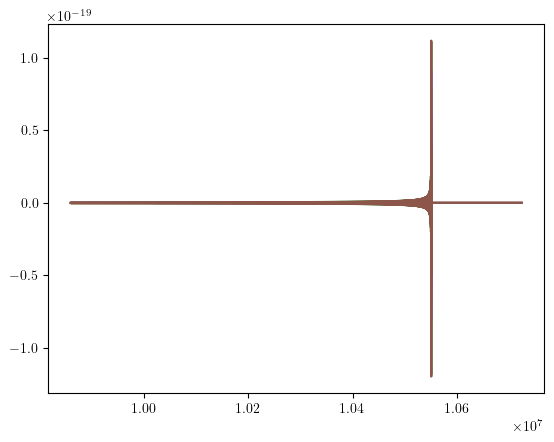

In [31]:
for ikey, key in enumerate(MOSA_labels):
    plt.plot(tcb_times, eta[ikey])
# plt.xlim(tcb_times[-1] - 20000, tcb_times[-1])
# plt.ylim(-1e-24, 1e-24)

## TDI 

In [32]:
m = dict(eta={key:eta[ikey] for ikey, key in enumerate(MOSA_labels)})
ltt = dict()
for key in MOSA_labels:
    ltt[key] = orbit.LTTfunctions()[key](tcb_times)
ltt = MOSADict(ltt)

tdi = TDI(measurements=m, delays=ltt, fsample=1./dt, order=11)
tdi.FastMichelson(doppler=False, channel="XYZ")

In [33]:
channel_names = ["X2", "Y2", "Z2"]

drop_point = int(1500./dt)

for nch in channel_names: 
    tdi.measurements[nch][:drop_point] = 0. 
    tdi.measurements[nch][-drop_point:] = 0. 

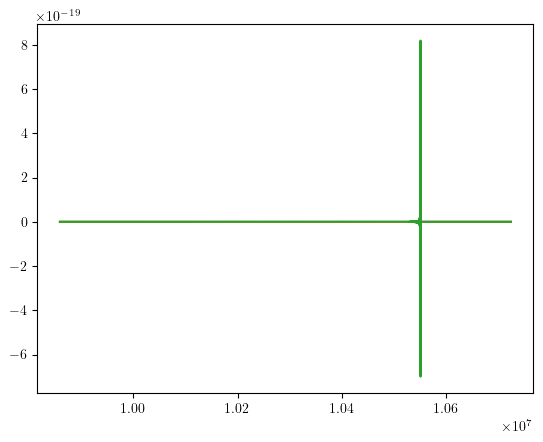

In [34]:
for nch in channel_names: 
    plt.plot(tcb_times, tdi.measurements[nch])
# plt.xlim(tcb_times[-1] - 20000, tcb_times[-1])
# plt.ylim(-1e-24, 1e-24)

In [35]:
data_channels = np.array([tdi.measurements[nch] for nch in channel_names])
data_channels.shape 

(3, 172800)

## Fast michelson response 

In [36]:
fast_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times.copy(),
    use_gpu=False, 
    drop_points=int(1500./dt), 
    interp_method="Spline5", 
)

In [37]:
model_channels = fast_response_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator, optimal_combination=False)
model_channels.shape 

(3, 172800)

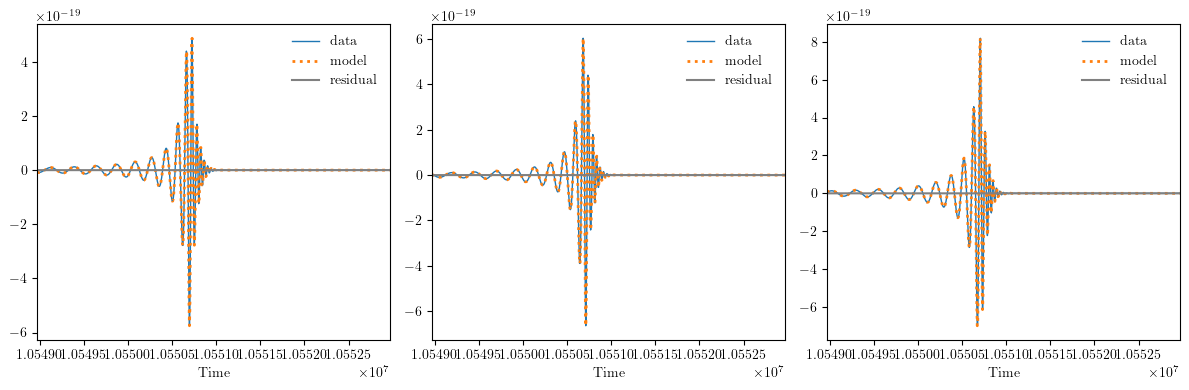

In [38]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(131+i)
    plt.plot(tcb_times, data_channels[i], label="data", linewidth=1)
    plt.plot(tcb_times, model_channels[i], label="model", linestyle=":", linewidth=2)
    plt.plot(tcb_times, data_channels[i] - model_channels[i], label="residual", color="grey")
    plt.xlabel("Time")
    plt.xlim(parameters["coalescence_time"] * DAY - 2000, parameters["coalescence_time"] * DAY + 2000)
    # plt.ylim(-1e-20, 1e-20)
    plt.legend(loc="upper right", frameon=False)
plt.tight_layout()

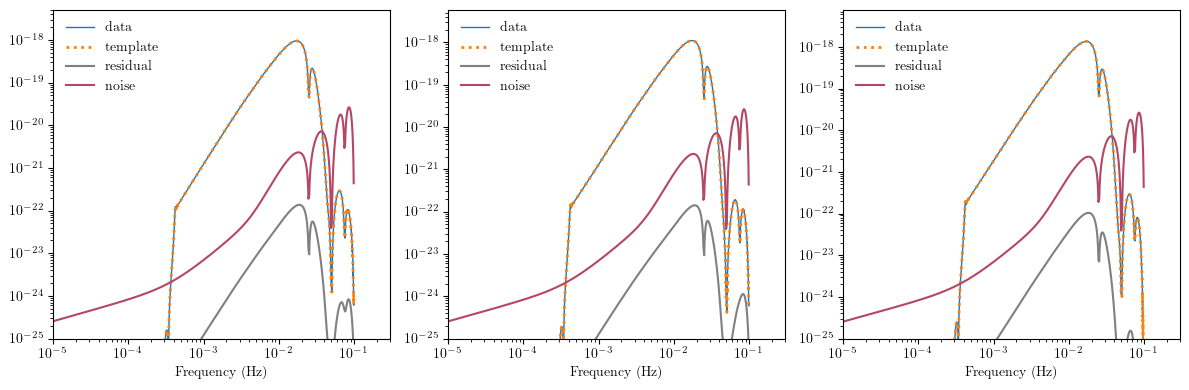

In [39]:
plt.figure(figsize=(12, 4))
win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.05))
PSDfunc = TDIPSDs()
for ich in range(3):
    plt.subplot(131+ich)
    ff, xf = FFT_window(data_channels[ich], 1./dt, **win_args)
    mask = np.ones_like(ff, dtype=bool)
    for nn in range(1, 40): 
        mask_idx = np.where(np.abs(ff-nn*0.025)<3e-4*nn)[0]
        mask[mask_idx] = False 
    plt.loglog(ff[mask], np.abs(xf[mask]) * 2 * ff[mask], label="data", linewidth=1)
    _, xf1 = FFT_window(model_channels[ich], 1./dt, **win_args)
    plt.loglog(ff[mask], np.abs(xf1[mask]) * 2 * ff[mask], label="template", linestyle=":", linewidth=2)
    _, xf2 = FFT_window(model_channels[ich] - data_channels[ich], 1./dt, **win_args)
    plt.loglog(ff[mask], np.abs(xf2[mask]) * 2 * ff[mask], label="residual", color="grey")
    plt.loglog(ff[mask], np.sqrt(PSDfunc.PSD_X2(ff) * ff)[mask], label="noise", color=RED)
    plt.xlabel("Frequency (Hz)")
    plt.xlim(1e-5, 0.3)
    plt.ylim(1e-25,)
    plt.legend(loc="upper left", frameon=False)
plt.tight_layout()